<a href="https://colab.research.google.com/github/viczsaurav/Algorithms/blob/master/unity_ads_bq_admin_prd_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install google-cloud-bigquery --quiet
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()

import datetime
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [ ]:
def run_query(sql):
    client = bigquery.Client(project="unity-ads-bq-adhoc-prd")
    job = client.query(sql)
    return job.result().to_dataframe()

### Analyse saturation


In [ ]:
query = """
with t as (
  select
    period_start,
    reservation_id,
    autoscale.current_slots AS autoscale_current_slots,
    autoscale.max_slots as autoscale_max_slots,
  from `unity-ads-bq-admin-prd.region-us`.INFORMATION_SCHEMA.RESERVATIONS_TIMELINE
  where 1=1
    and period_start >= timestamp_sub(current_timestamp(), interval 14 day)
    #and reservation_id like "%dd-de-prd%"
)

select
  TIMESTAMP_TRUNC(period_start, HOUR) period_start,
  reservation_id,
  approx_quantiles(autoscale_current_slots, 100)[offset(90)] as current_slots_p90,
  max(autoscale_max_slots) as max_slots,
from t
group by 1,2
order by 1,2
"""
df_aa = run_query(query)

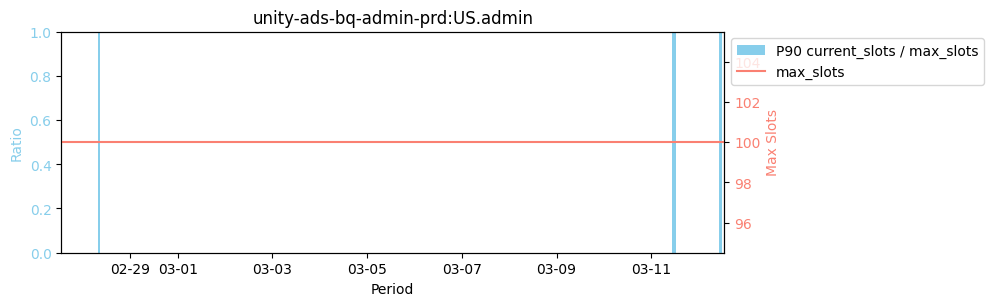

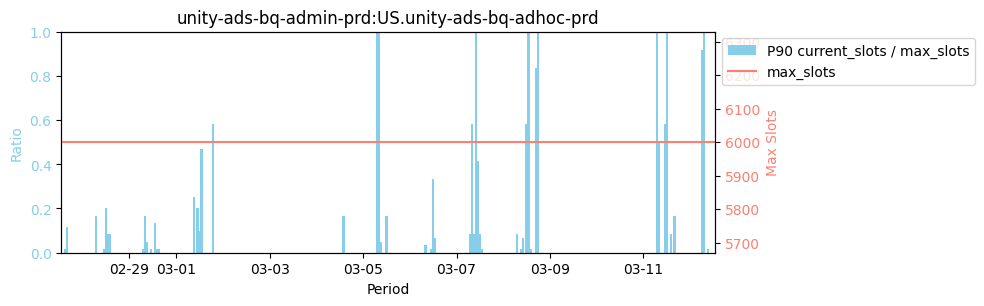

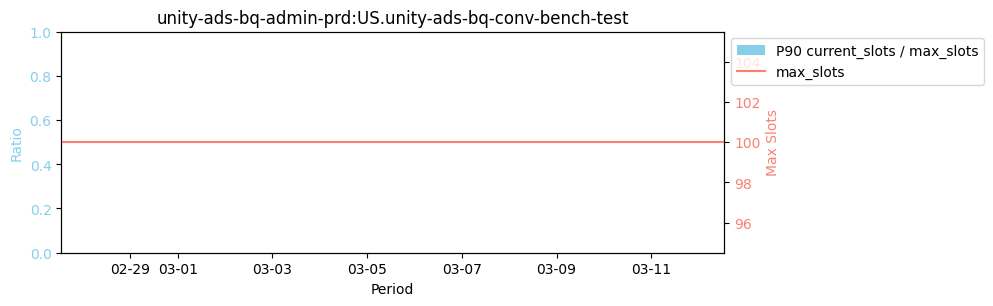

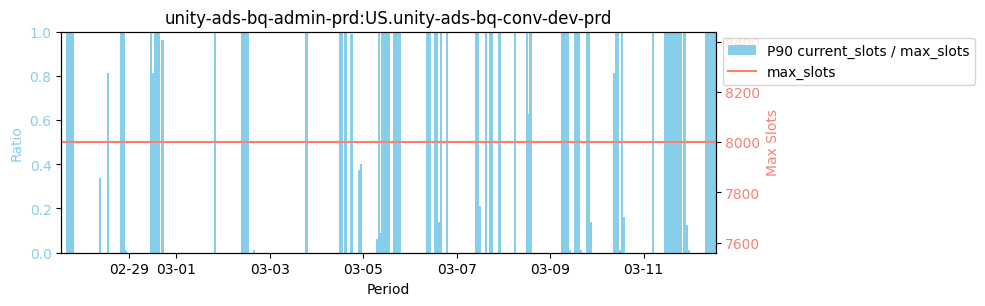

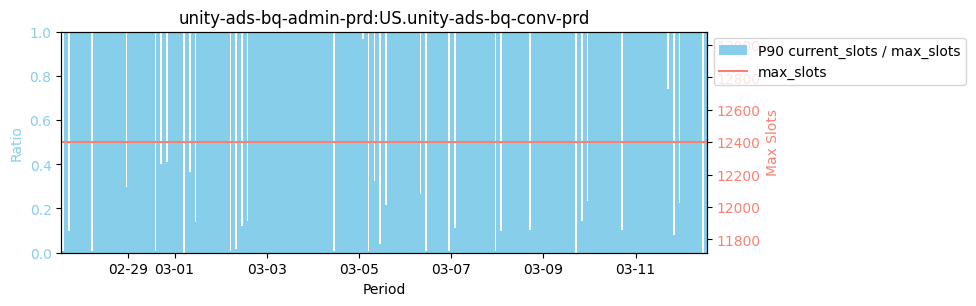

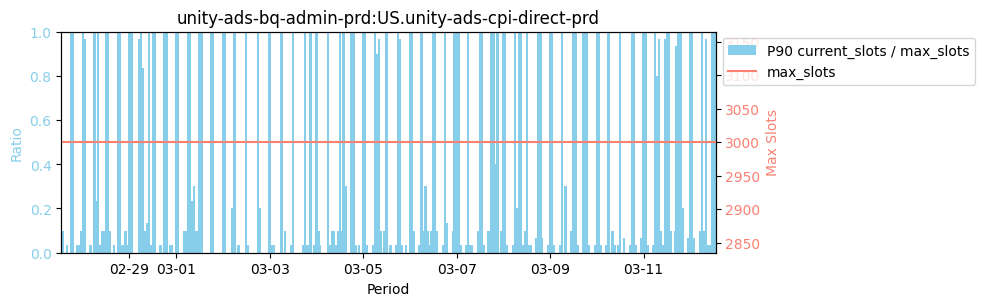

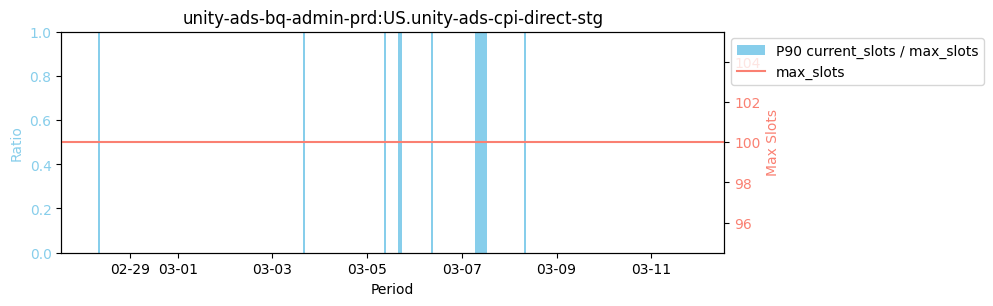

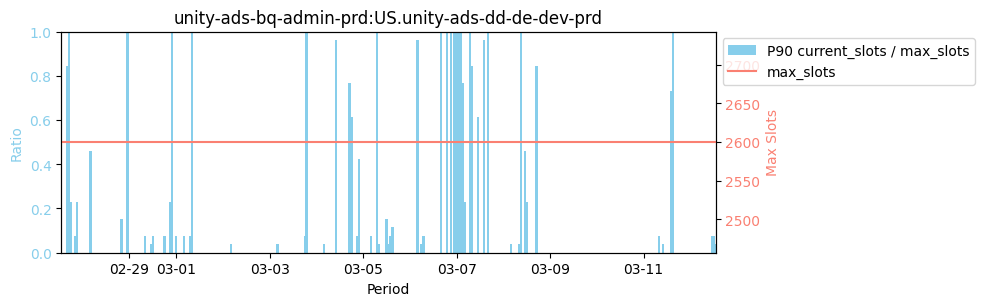

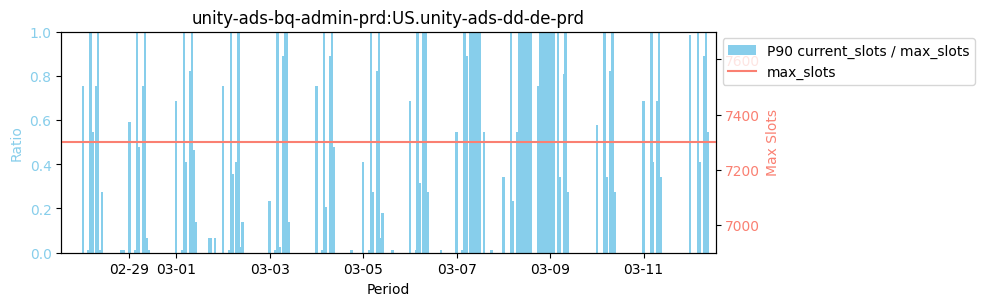

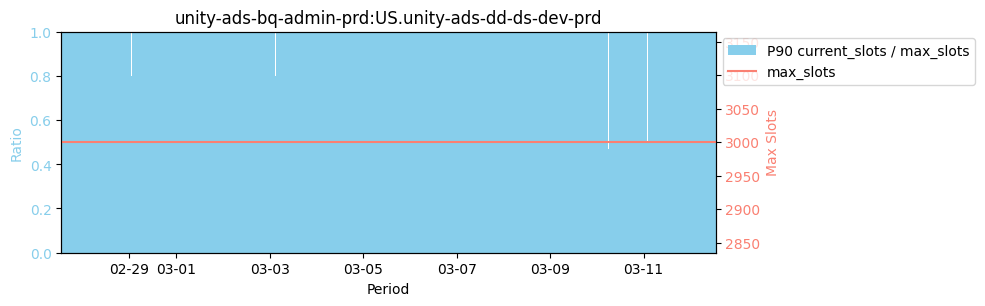

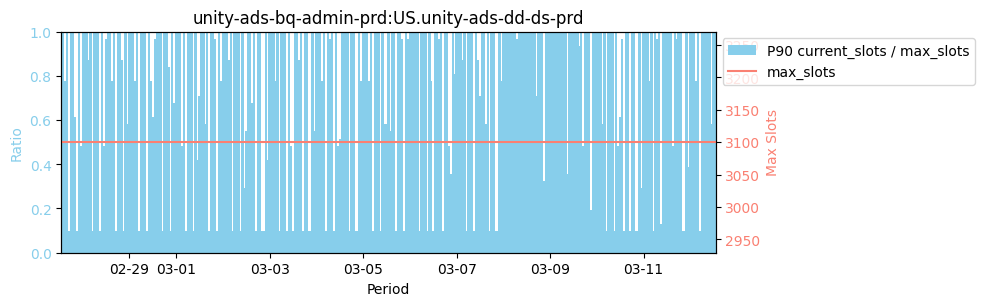

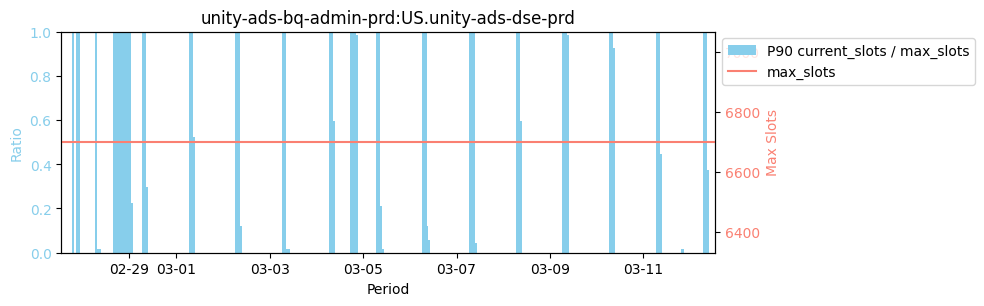

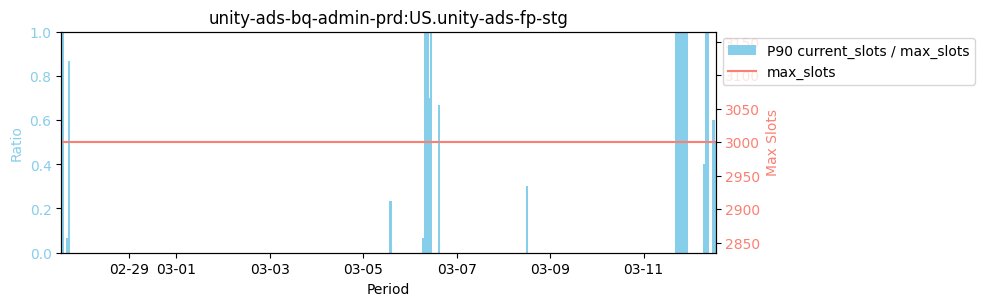

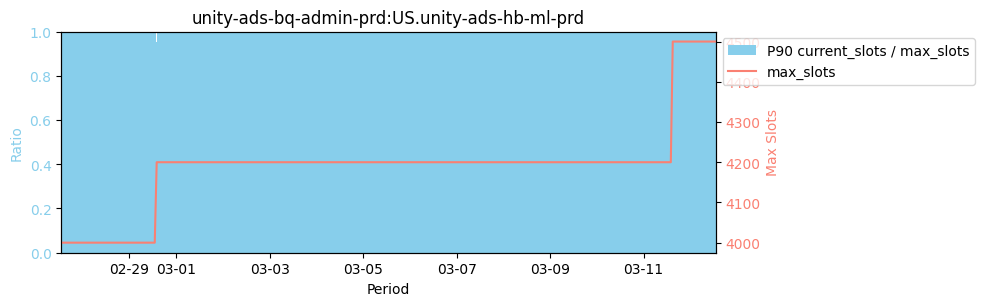

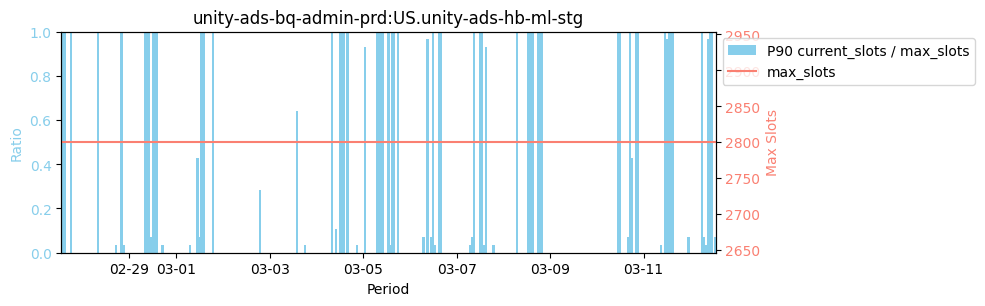

In [ ]:
df_aa["ratio"] = df_aa["current_slots_p90"] / df_aa["max_slots"]

for reservation_id in df_aa['reservation_id'].unique():
    project_data = df_aa[df_aa['reservation_id'] == reservation_id]

    # Plotting
    fig, ax1 = plt.subplots(figsize=(8, 3))

    # Plot the ratio as bars
    color = 'skyblue'
    ax1.bar(project_data['period_start'], project_data['ratio'], width=0.05, color=color, label='P90 current_slots / max_slots')
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Ratio', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim([0, 1])
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.set_xlim(project_data['period_start'].min(), project_data['period_start'].max())


    # Create a secondary y-axis for res_max_slots
    ax2 = ax1.twinx()
    color = 'salmon'
    ax2.plot(project_data['period_start'], project_data['max_slots'], color=color, label='max_slots')
    ax2.set_ylabel('Max Slots', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add legend
    fig.tight_layout()
    fig.legend(loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    # Rotate x-axis labels for better readability (optional)
    plt.xticks(rotation=45)

    # Show plot
    plt.title(reservation_id)
    plt.show()

## Analyse user queries

In [ ]:
query = """
select
  TIMESTAMP_TRUNC(period_start, HOUR) period_start,
  project_id,
  SUM(period_slot_ms) / 1000 / 60 / 60 AS period_slot_hour,
from `unity-ads-bq-admin-prd.region-us`.INFORMATION_SCHEMA.JOBS_TIMELINE_BY_ORGANIZATION
where 1=1
  and period_start >= timestamp_sub(current_timestamp(), interval 14 day)
  and user_email like "%@unity3d.com%"
  and reservation_id like "%unity-ads-bq-admin-prd%"
  and project_id != "unity-ads-bq-adhoc-prd"
  and project_id != "unity-ads-bq-conv-bench-test"
group by 1,2
order by 1 asc
"""
df_ab = run_query(query)

In [ ]:
df_ab

,period_start,project_id,period_slot_hour
0,2024-02-27 13:00:00+00:00,unity-ads-fp-stg,273.570519
1,2024-02-27 13:00:00+00:00,unity-ads-dd-ds-dev-prd,195.675503
2,2024-02-27 14:00:00+00:00,unity-ads-dd-ds-prd,4.913853
3,2024-02-27 14:00:00+00:00,unity-ads-dse-prd,0.001024
4,2024-02-27 14:00:00+00:00,unity-ads-dd-ds-dev-prd,308.283586
...,...,...,...
936,2024-03-12 13:00:00+00:00,unity-ads-dd-ds-prd,0.000614
937,2024-03-12 13:00:00+00:00,unity-ads-fp-stg,144.906052
938,2024-03-12 13:00:00+00:00,unity-ads-dd-de-dev-prd,2.020218
939,2024-03-12 13:00:00+00:00,unity-ads-hb-ml-stg,0.003360


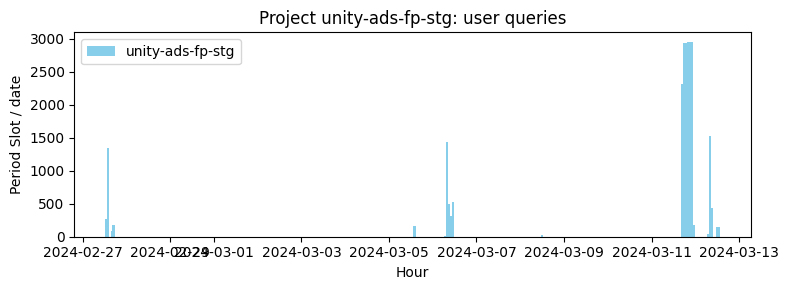

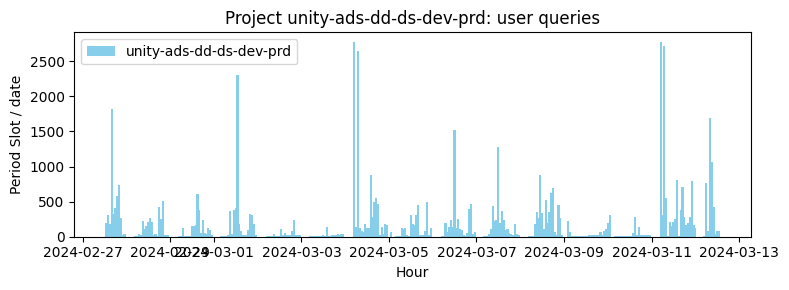

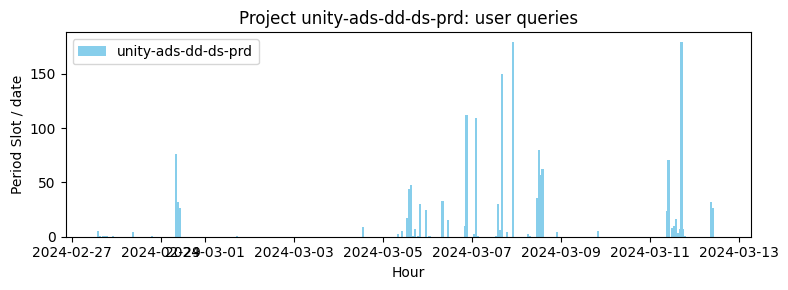

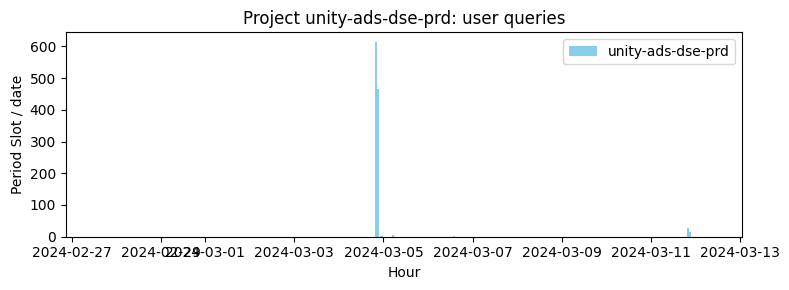

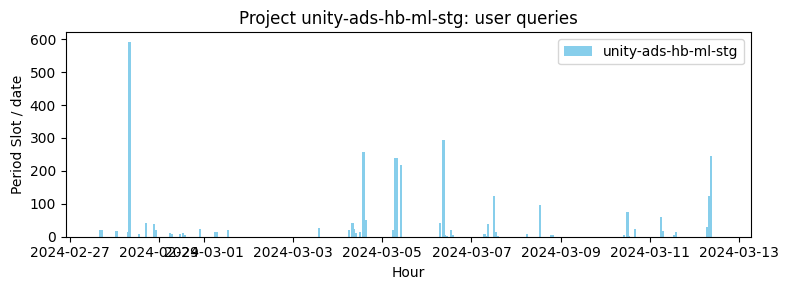

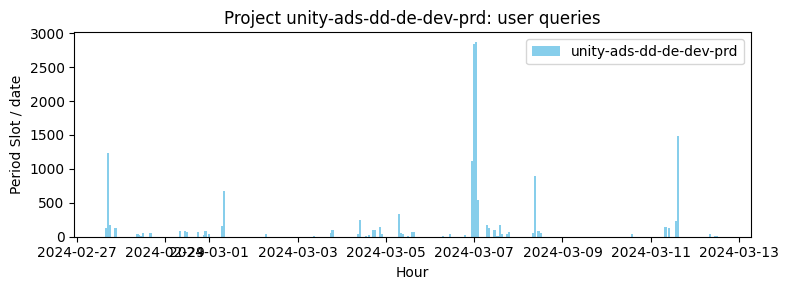

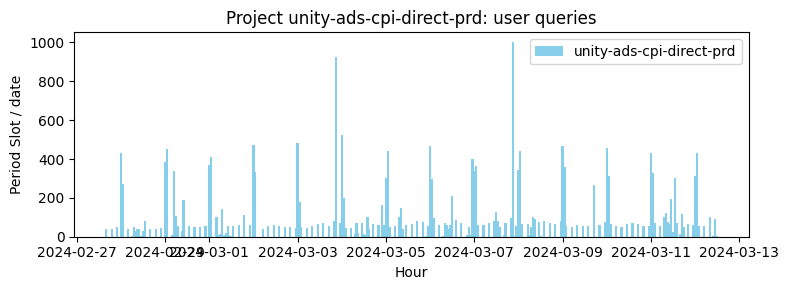

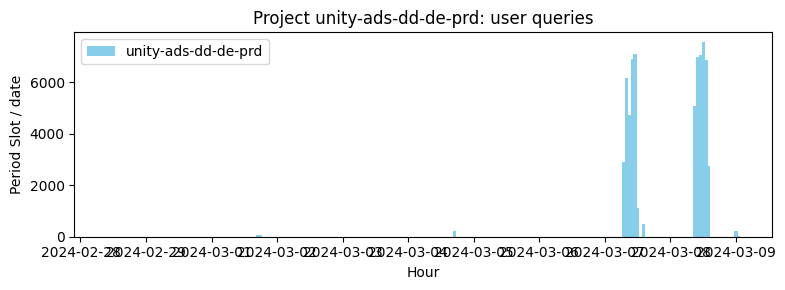

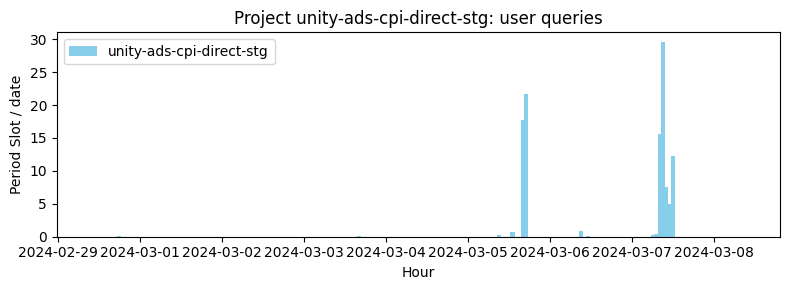

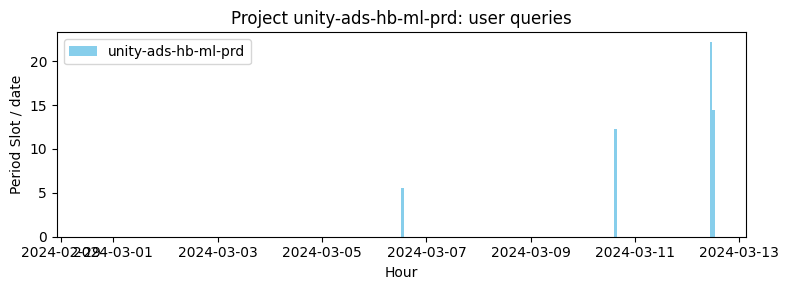

In [ ]:
# Get unique project ids
df_ab['period_start_datetime'] = pd.to_datetime(df_ab['period_start'])

# Plot for each project_id
for project_id in df_ab['project_id'].unique():
    # Filter data for the current project_id
    project_data = df_ab[df_ab['project_id'] == project_id]

    # Plotting
    plt.figure(figsize=(8, 3))

    # Plot X is period_start (hour) and Y is period_slot_minutes
    color = 'skyblue'
    plt.bar(project_data['period_start_datetime'], project_data['period_slot_hour'], width=0.05, color=color, label=project_id)

    # Add labels and title
    plt.xlabel('Hour')
    plt.ylabel('Period Slot / date')
    plt.title(f'Project {project_id}: user queries')
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

### Analyse costs per reservations through RESERVATIONS_TIMELINE
The results are almost identical to the [Billing report](https://console.cloud.google.com/billing/010535-869B52-5BFAB1/reports;timeRange=YEAR_TO_DATE;grouping=GROUP_BY_SKU;timeGrouping=GROUP_BY_MONTH;projects=unity-ads-bq-admin-prd;products=services%2F16B8-3DDA-9F10;skus=services%2F16B8-3DDA-9F10%2Fskus%2FC0F6-38AB-6629;credits=SUSTAINED_USAGE_DISCOUNT,SPENDING_BASED_DISCOUNT,COMMITTED_USAGE_DISCOUNT,FREE_TIER,COMMITTED_USAGE_DISCOUNT_DOLLAR_BASE,SUBSCRIPTION_BENEFIT?organizationId=1025476173892&project=unity-ads-re-prd-prd) when the `ignore_idle_slots=true`. The `--ignore_idle_slots` flag controls whether queries running in a reservation can use idle slots from other reservations. If the flag is not set, reservations may consume idle slots from other reservations, resulting in incorrect cost allocation among reservations.

In [ ]:
# total costs, for all reservations together
query = """
select
  TIMESTAMP_TRUNC(period_start, MONTH) month,
  #reservation_id,
  #round(sum(slots_assigned + autoscale.current_slots) / 60) slot_hours,
  round(sum(slots_assigned + autoscale.current_slots) / 60 * 0.0468) slot_usd
from `unity-ads-bq-admin-prd.region-us`.INFORMATION_SCHEMA.RESERVATIONS_TIMELINE
where period_start >= timestamp_sub(current_timestamp(), interval 180 day)
group by 1#,2
order by 1#,2
"""
df1 = run_query(query)
px.bar(df1, x='month', y='slot_usd', color_discrete_sequence=px.colors.qualitative.Plotly)

In [ ]:
# Group by MONTH
query = """
select
  TIMESTAMP_TRUNC(period_start, MONTH) month,
  reservation_id,
  #round(sum(slots_assigned + autoscale.current_slots) / 60) slot_hours,
  round(sum(slots_assigned + autoscale.current_slots) / 60 * 0.0468) slot_usd
from `unity-ads-bq-admin-prd.region-us`.INFORMATION_SCHEMA.RESERVATIONS_TIMELINE
where period_start >= timestamp_sub(current_timestamp(), interval 180 day)
group by 1,2
order by 1,2
"""
df2 = run_query(query)
fig2 = px.bar(df2, x='month', y='slot_usd', color='reservation_id', color_discrete_sequence=px.colors.qualitative.Plotly)
fig2.update_layout()

In [ ]:
# Group by DAY
query = """
select
  TIMESTAMP_TRUNC(period_start, DAY) day,
  reservation_id,
  #round(sum(slots_assigned + autoscale.current_slots) / 60) slot_hours,
  round(sum(slots_assigned + autoscale.current_slots) / 60 * 0.0468) slot_usd
from `unity-ads-bq-admin-prd.region-us`.INFORMATION_SCHEMA.RESERVATIONS_TIMELINE
where period_start >= timestamp_sub(current_timestamp(), interval 180 day)
group by 1,2
order by 1,2
"""
df3 = run_query(query)
fig3 = px.bar(df3, x='day', y='slot_usd', color='reservation_id', color_discrete_sequence=px.colors.qualitative.Plotly)
fig3.update_layout()

In [ ]:
fig4 = px.line(df3, x='day', y='slot_usd', color='reservation_id', color_discrete_sequence=px.colors.qualitative.Plotly)
fig4.update_layout()

### Analyse cost differences between slots and bytes

It's very approximate and works only in cases when `ignore_idle_slots=true`, because otherwise, jobs use slots from other reservations and the entire cost attribution is messed up. Even then, it still may be incorrect for reservations with over-utilizations.

In [ ]:
query = """
DECLARE tb_divisor INT64 DEFAULT 1024*1024*1024*1024;
DECLARE cost_per_tb_in_dollar FLOAT64 DEFAULT 5.11; # $6.25 per TB minus discount = $5.11
DECLARE bytes_cost_factor FLOAT64 DEFAULT cost_per_tb_in_dollar / tb_divisor;
DECLARE slot_hour_cost_factor FLOAT64 DEFAULT 0.0468 / 60; # Pay as you go: 1/slot/hour = 0.0468 inc. 22% discount

with t_slots as (
  SELECT
    project_id,
    TIMESTAMP_TRUNC(period_start, MINUTE) period_start,
    SUM(period_slot_ms) / 1000 / 60 AS period_slot_minutes,
  FROM
    `unity-ads-bq-admin-prd.region-us`.INFORMATION_SCHEMA.JOBS_TIMELINE_BY_ORGANIZATION
  WHERE 1=1
    and job_creation_time >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 180 DAY)
    AND (statement_type != "SCRIPT" OR statement_type IS NULL)
    AND user_email not like "%unity3d.com%"
  GROUP BY 1,2
)

, t_slots_month as (
  select
    project_id,
    TIMESTAMP_TRUNC(period_start, MONTH) period,
    round(sum(period_slot_minutes) * slot_hour_cost_factor) as usd_job_slots,
  from t_slots
  group by 1,2
)

, t_bytes_billed as (
  SELECT
    start_time,
    project_id,
    total_bytes_billed,
  FROM `unity-ads-bq-admin-prd.region-us`.INFORMATION_SCHEMA.JOBS_BY_ORGANIZATION
  WHERE 1=1
    and start_time >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 180 DAY)
    AND (statement_type != "SCRIPT" OR statement_type IS NULL)
    and total_bytes_billed is not null
    AND user_email not like "%unity3d.com%"
)

select
  b.project_id,
  period,
  any_value(t.usd_job_slots) usd_job_slots,
  round(sum(total_bytes_billed * bytes_cost_factor)) usd_bytes_billed

from t_bytes_billed as b
left join t_slots_month as t
  on TIMESTAMP_TRUNC(start_time, MONTH) = t.period and b.project_id = t.project_id
group by 1,2
order by 1,2 asc
"""
df_b = run_query(query)

# Create another column when usd_job_slots is not null and usd_bytes_billed is not null
df_b['cost_saving'] =  df_b.apply(lambda row: row['usd_bytes_billed'] - row['usd_job_slots'] if row['usd_job_slots'] is not None and row['usd_bytes_billed'] is not None else None, axis=1)

#### For current projects

In [ ]:
# Calculate cost savings between bytes and reservations for the entire period
# we compare with reservation, not with jobs usage, because we are billed by reservation!
df_sum = df_b.groupby(['project_id', 'period', 'usd_job_slots', 'usd_bytes_billed'])[['cost_saving']].sum().reset_index()
df_sum

,project_id,period,usd_job_slots,usd_bytes_billed,cost_saving
0,deltadna-live,2023-09-01 00:00:00+00:00,0.0,0.0,0.0
1,deltadna-live,2023-10-01 00:00:00+00:00,1.0,1.0,0.0
2,deltadna-live,2023-11-01 00:00:00+00:00,1.0,1.0,0.0
3,deltadna-live,2023-12-01 00:00:00+00:00,0.0,0.0,0.0
4,deltadna-live,2024-01-01 00:00:00+00:00,0.0,0.0,0.0
...,...,...,...,...,...
1599,vivox-data-f59b,2024-01-01 00:00:00+00:00,162.0,987.0,825.0
1600,vivox-data-f59b,2024-02-01 00:00:00+00:00,198.0,965.0,767.0
1601,vivox-data-f59b,2024-03-01 00:00:00+00:00,58.0,187.0,129.0
1602,vivox-gcp-integration-tests,2023-11-01 00:00:00+00:00,0.0,0.0,0.0


In [ ]:
# Total cost saving for ML/DS/Eng projects for the entire period (180 days)
projects_to_filter = [
    'unity-ads-bq-adhoc-prd',
    'unity-ads-dd-ds-prd',
    'unity-ads-dd-ds-dev-prd',
    'unity-ads-bq-conv-dev-prd',
    'unity-ads-bq-conv-bench-test',
    'unity-ads-bq-conv-prd',
    'unity-ads-dd-de-prd',
    'unity-ads-dd-de-dev-prd',
    'unity-ads-hb-ml-prd',
    'unity-ads-hb-ml-stg',
    'unity-ads-cpi-direct-prd',
    'unity-ads-cpi-direct-stg',
    'unity-ads-fp-stg',
]
df_sum['cost_saving'][df_b['project_id'].isin(projects_to_filter)].sum()

15541041.0

#### For potential new candidates
Double check number with the [billing report](https://console.cloud.google.com/billing/010535-869B52-5BFAB1/reports;timeRange=LAST_90_DAYS;grouping=GROUP_BY_PROJECT;timeGrouping=GROUP_BY_MONTH;projects=unity-ads-cpi-direct-prd,unity-ads-cpi-direct-stg,unity-ads-cpi-direct-test,unity-ads-cpi-ext-prd,unity-ads-cpi-ext-stg,unity-ads-dd-de-dev-prd,unity-ads-dd-de-stg,unity-ads-dd-ds-dev-prd,unity-ads-dse-prd,unity-ads-dse-stg;products=services%2F24E6-581D-38E5,services%2F650B-3C82-34DB,services%2F16B8-3DDA-9F10,services%2FDCC9-8DB9-673F;credits=CREDIT_TYPE_UNSPECIFIED,PROMOTION,SUSTAINED_USAGE_DISCOUNT,SPENDING_BASED_DISCOUNT,COMMITTED_USAGE_DISCOUNT,FREE_TIER,COMMITTED_USAGE_DISCOUNT_DOLLAR_BASE,SUBSCRIPTION_BENEFIT?organizationId=1025476173892&project=unity-ads-re-prd-prd). I checked the cost per byte using the billing report and some of them look legit (although some are less than the billing report, not sure why).


In [ ]:
df_b.sort_values(by='cost_saving', ascending=False)

,project_id,period,usd_job_slots,usd_bytes_billed,cost_saving
115,unity-ads-bq-conv-prd,2024-02-01 00:00:00+00:00,242443.0,2678768.0,2436325.0
114,unity-ads-bq-conv-prd,2024-01-01 00:00:00+00:00,189650.0,2519579.0,2329929.0
113,unity-ads-bq-conv-prd,2023-12-01 00:00:00+00:00,105278.0,1972140.0,1866862.0
112,unity-ads-bq-conv-prd,2023-11-01 00:00:00+00:00,33096.0,1528812.0,1495716.0
116,unity-ads-bq-conv-prd,2024-03-01 00:00:00+00:00,107527.0,1504949.0,1397422.0
...,...,...,...,...,...
504,unity-ai-data-prd,2023-12-01 00:00:00+00:00,17044.0,8671.0,-8373.0
505,unity-ai-data-prd,2024-01-01 00:00:00+00:00,17854.0,8137.0,-9717.0
503,unity-ai-data-prd,2023-11-01 00:00:00+00:00,17291.0,7229.0,-10062.0
506,unity-ai-data-prd,2024-02-01 00:00:00+00:00,17637.0,7287.0,-10350.0


In [ ]:
df_candidates = df_b.groupby(['project_id']).agg({'cost_saving': 'sum'})
projects_to_filter = [
    "unity-ads-dse-prd",
    "unity-ads-dse-stg",
    "unity-ads-ds-prd",
    "unity-ads-app-event-prd",
    "unity-ads-app-event-stg",
    "unity-ads-exchg-gke-prd",
    "unity-ads-gke-prd",
    "unity-ads-insights-prd",
    "unity-ads-ml-fraud-prd",
    "unity-ads-wolfi-ml-prd",
    "unity-ai-unity-insights-prd",
]
df_candidates[df_candidates.index.isin(projects_to_filter)].sort_values(by='cost_saving', ascending=False)


,cost_saving
project_id,
unity-ads-dse-prd,115604.0
unity-ai-unity-insights-prd,41015.0
unity-ads-ds-prd,23700.0
unity-ads-app-event-prd,16420.0
unity-ads-gke-prd,14419.0
unity-ads-insights-prd,13811.0
unity-ads-ml-fraud-prd,11708.0
unity-ads-exchg-gke-prd,11553.0
unity-ads-app-event-stg,10721.0


### Analyse P90 slots utilisation
I uses data for the past 2 weeks. This seems to match the Slot Estimator, assuming `ignore_idle_slots=true`.

In [ ]:
query = """
with t as (
  SELECT
    project_id,
    #job_id,
    period_start,
    period_slot_ms / 1000 period_slot_second,
  FROM
    `unity-ads-bq-admin-prd.region-us`.INFORMATION_SCHEMA.JOBS_TIMELINE_BY_ORGANIZATION
  WHERE 1=1
    and job_creation_time BETWEEN TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 7 DAY) AND CURRENT_TIMESTAMP()
    and (statement_type != "SCRIPT" OR statement_type IS NULL) -- Avoid duplicate byte counting in parent and children jobs.
    #and job_id = "cbe48500-a882-4259-8ee8-5cce80c4fcd0"    # for example, for a single job
  order by period_slot_ms desc
)

, t2 as (
  select
    project_id,
    TIMESTAMP_TRUNC(period_start, DAY) period,
    approx_quantiles(period_slot_second, 100)[offset(90)] as job_slots_p90,
    approx_quantiles(period_slot_second, 100)[offset(99)] as job_slots_p99,

  from t
  group by 1,2
)

select
  project_id,
  round(max(job_slots_p90)) max_daily_p90,
  round(max(job_slots_p99)) max_daily_p99,
from t2
group by 1
"""
df_p90 = run_query(query)
df_p90

,project_id,max_daily_p90,max_daily_p99
0,unity-it-open-dataplatform-prd,885.0,1533.0
1,unity-it-iltools-prd,4.0,269.0
2,unity-corp-raw-data-prd,0.0,1.0
3,vivox-data-f59b,81.0,634.0
4,unity-ow-bi-tableau-prd,111.0,114.0
...,...,...,...
193,unity-data-ads-products-test,0.0,0.0
194,unity-analytics-common-stg,945.0,2844.0
195,tj-data-platform,18.0,35.0
196,unity-rd-perf-test-data-stg,0.0,0.0


### Analyse jobs executed by third-party service accounts
In some cases, our projects run jobs using service accounts from different projects, which can mess up how we track costs. It's actually way better if we can make sure that all the jobs for a project are done within that same project. This way, we can keep things tidy and keep a closer eye on our expenses

### Analyse over-utilisation of slots by reservations
The purpose of this metric is to show cases where slot usage based on job metadata exceeds the `max_slots` allowed by autoscaling. This only makes sense when `ignore_idle_slots=true`, since otherwise jobs running in a reservation can use (steal) idle slots from other reservations.

**According to Google**: Sometimes more slots might be allocated than the autoscaler max slots and this usage will be reported in the jobs in INFORMATION_SCHEMA table. However you won’t be overcharged for these slots since the billing is based on the autoscale of current slots. [Google Support ticket #46911926](https://console.cloud.google.com/support/cases/detail/v2/46911926?project=unity-ads-bq-admin-prd)

In [ ]:
query = """
with t as (
  SELECT
    res.reservation_id,
    res.period_start,
    SUM(jobs.period_slot_ms) / 1000 / 60 AS period_slot_minutes,
    ANY_VALUE(res.slots_assigned) AS slot_assigned,
    ANY_VALUE(res.autoscale.max_slots) as autoscale_max_slots,
    ANY_VALUE(res.autoscale.current_slots) AS autoscale_current_slots, # 100 IS A MINIMUM STEP
  FROM
    `unity-ads-bq-admin-prd.region-us`.INFORMATION_SCHEMA.JOBS_TIMELINE_BY_ORGANIZATION jobs
  JOIN
    `unity-ads-bq-admin-prd.region-us`.INFORMATION_SCHEMA.RESERVATIONS_TIMELINE res
    ON
      TIMESTAMP_TRUNC(jobs.period_start, MINUTE) = res.period_start
      AND jobs.reservation_id = res.reservation_id
  WHERE 1=1
    and jobs.job_creation_time BETWEEN TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY) AND CURRENT_TIMESTAMP()
    AND (jobs.statement_type != "SCRIPT" OR jobs.statement_type IS NULL)  -- Avoid duplicate byte counting in parent and children jobs.
    AND ignore_idle_slots = true
  GROUP BY 1,2
  ORDER BY 1 asc
)

,t2 as (
  select
    reservation_id,
    TIMESTAMP_TRUNC(period_start, DAY) day,
    safe_divide(period_slot_minutes, autoscale_max_slots) as ratio,
  from t
)

select
  reservation_id,
  day,
  SUM(CASE WHEN ratio > 1.05 THEN 1 ELSE 0 END) / COUNT(*) AS ratio_gt_1_05_fraction # jobs/autoscale_max_slots > 1.05
from t2
group by 1,2
order by day
"""
df_ratio = run_query(query)

In [ ]:
px.bar(df_ratio, x='day', y='ratio_gt_1_05_fraction', color='reservation_id', color_discrete_sequence=px.colors.qualitative.Plotly)


In [ ]:
query = """
SELECT
  project_id,
  user_email,
  count(*) as n,
FROM unity-ads-dd-de-dev-prd.`region-us`.INFORMATION_SCHEMA.JOBS_BY_ORGANIZATION
WHERE 1=1
  and creation_time >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 7 DAY)
  and user_email not like "%@unity3d.com%"              # exclude ad-hoc users, it's a separate issue
  and user_email not like CONCAT('%', project_id, '%')  # exclude own service accounts
  and user_email not like "%unity-ai-data-mlp%"         # legit case
  and user_email not like "%bigquery-adminbot%"
  and project_id in (
    "unity-ads-dd-ds-prd",
    "unity-ads-dd-ds-dev-prd",
    "unity-ads-dd-de-prd",
    "unity-ads-dd-de-dev-prd",
    "unity-ads-bq-conv-prd",
    "unity-ads-bq-conv-dev-prd",
    "unity-ads-cpi-direct-prd",
    "unity-ads-cpi-direct-stg",
    "unity-ads-hb-ml-prd",
    "unity-ads-hb-ml-stg",
    "unity-ads-dse-prd",
    "unity-ads-dse-stg"
  )
group by 1,2
order by n desc
"""
df_sa = run_query(query)
df_sa

,project_id,user_email,n
0,unity-ads-hb-ml-prd,952775079031-compute@developer.gserviceaccount...,2107
1,unity-ads-hb-ml-stg,14844811013-compute@developer.gserviceaccount.com,61
2,unity-ads-dse-stg,unity-ads-dse@unity-ads-gke-stg.iam.gserviceac...,8
3,unity-ads-dd-ds-dev-prd,654293578935-compute@developer.gserviceaccount...,7
4,unity-ads-dse-prd,unity-ads-dse@unity-ads-gke-prd.iam.gserviceac...,7
